In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
Pop = pd.read_csv("/content/Tomates+météo - Tableau 1 (1).csv")
Pop=Pop.iloc[pd.to_datetime(Pop.Date.astype(str)).argsort()]
Pop

,Date,prix moyen au kg,prix minimal,prix maximal,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
354,01/08/12,1.30,1.3,1.3,0.20,11.8,28.0,0.4,445,44.4,Tomate ronde cat.I 57-67mm
333,01/10/12,1.10,1.1,1.1,0.20,3.5,19.1,0.8,536,40.7,Tomate ronde cat.I 57-67mm
332,02/10/12,1.10,1.1,1.1,0.20,12.8,18.8,0.2,121,38.9,Tomate ronde cat.I 57-67mm
353,03/08/12,1.25,1.2,1.3,0.30,12.0,24.1,0.4,330,42.8,Tomate ronde cat.I 57-67mm
342,04/09/12,1.10,1.1,1.1,0.40,12.8,25.7,0.0,672,37.0,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,1.7,1.8,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 67-82mm
19,11/09/20,1.05,1.0,1.1,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 57-67mm
373,19/11/20,1.80,NaN,NaN,0.05,5.8,11.5,0.0,352,61.2,Tomate ronde cat.I 67-82mm
372,20/11/20,1.50,NaN,NaN,0.10,-0.1,10.6,0.0,297,26.3,Tomate ronde cat.I 67-82mm


In [ ]:
Pop = Pop.drop(["prix maximal","prix minimal"], axis=1)
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4,Tomate ronde cat.I 57-67mm
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7,Tomate ronde cat.I 57-67mm
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9,Tomate ronde cat.I 57-67mm
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8,Tomate ronde cat.I 57-67mm
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 67-82mm
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 57-67mm
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2,Tomate ronde cat.I 67-82mm
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3,Tomate ronde cat.I 67-82mm


In [ ]:
Pop.describe()

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
count,421.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,1.264798,0.464830,12.051651,23.908726,1.475236,436.160377,40.075472
std,0.288990,0.776784,3.965298,5.803186,4.417398,266.967955,12.427627
min,0.500000,0.016000,-0.100000,6.600000,0.000000,0.000000,14.400000
25%,1.050000,0.100000,9.800000,20.100000,0.000000,210.000000,31.500000
50%,1.200000,0.240000,12.300000,23.700000,0.000000,447.500000,38.900000
75%,1.500000,0.500000,14.700000,28.000000,0.400000,658.500000,46.800000
max,2.000000,7.680000,23.200000,41.300000,31.900000,906.000000,92.600000


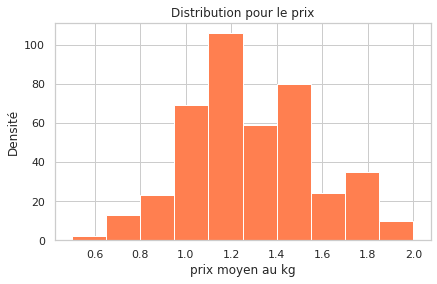

skew= 0.22827047693351465


In [ ]:
plt.hist(Pop['prix moyen au kg'],color ='coral')
plt.title('Distribution pour le prix')
plt.xlabel('prix moyen au kg')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['prix moyen au kg'].skew())

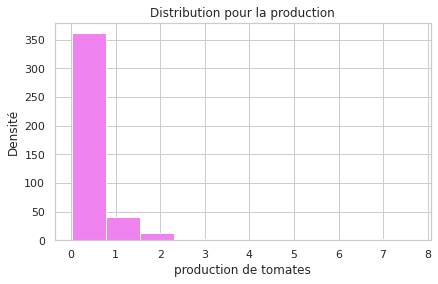

skew= 5.583569472053098


In [ ]:
plt.hist(Pop['Production quantité \ntonne(s)'],color ='violet')
plt.title('Distribution pour la production')
plt.xlabel('production de tomates')
plt.ylabel('Densité')
plt.show()
print ("skew=", Pop['Production quantité \ntonne(s)'].skew())

In [ ]:
Pop['catégorie tomates'].value_counts().to_frame()

,catégorie tomates
Tomate ronde cat.I 57-67mm,372
Tomate ronde cat.I 67-82mm,52


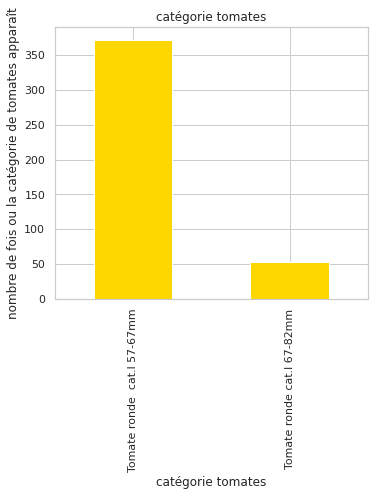

In [ ]:
Pop['catégorie tomates'].value_counts().plot(kind='bar',figsize=(5,5),title= 'catégorie tomates',color ='gold')
plt.xlabel('catégorie tomates')
plt.ylabel("nombre de fois ou la catégorie de tomates apparaît")
plt.show()

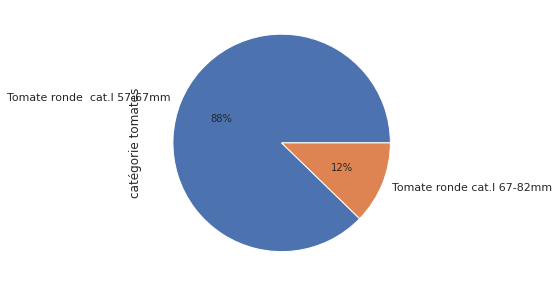

In [ ]:
Pop['catégorie tomates'].value_counts().plot(kind='pie', figsize=[5,5],
          autopct=lambda p: '{:.0f}%'.format(p,(p/100)*Pop['catégorie tomates'].value_counts().sum()))

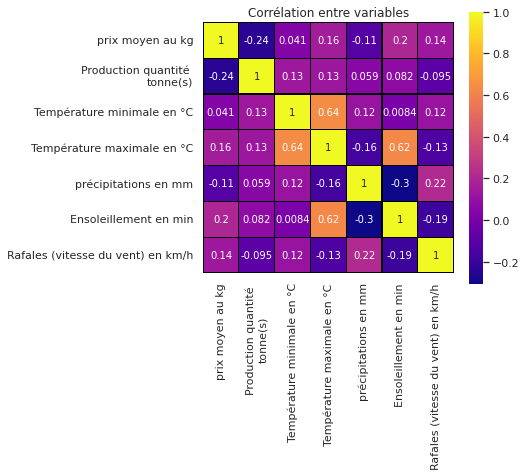

In [ ]:
Corr = Pop.corr()


f, ax = plt.subplots(figsize=(5,5))
plt.title('Corrélation entre variables')


sns.heatmap(Corr,linewidths=0.25,vmax=1.0, square=True, cmap="plasma", linecolor='black', annot=True)
plt.show()

In [ ]:
Pop =  Pop.interpolate() #pour remplacer les valeurs nulles par une valeur moyenne
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4,Tomate ronde cat.I 57-67mm
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7,Tomate ronde cat.I 57-67mm
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9,Tomate ronde cat.I 57-67mm
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8,Tomate ronde cat.I 57-67mm
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0,Tomate ronde cat.I 57-67mm
...,...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 67-82mm
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 57-67mm
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2,Tomate ronde cat.I 67-82mm
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3,Tomate ronde cat.I 67-82mm


In [ ]:
dummy_tomate1 = pd.get_dummies(Pop['catégorie tomates'])
dummy_tomate1

,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
354,1,0
333,1,0
332,1,0
353,1,0
342,1,0
...,...,...
388,0,1
19,1,0
373,0,1
372,0,1


In [ ]:
T =  pd.merge(
    left=Pop,
    right=dummy_tomate1,
    left_index=True,
    right_index=True,
)

T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,catégorie tomates,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4,Tomate ronde cat.I 57-67mm,1,0
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7,Tomate ronde cat.I 57-67mm,1,0
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9,Tomate ronde cat.I 57-67mm,1,0
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8,Tomate ronde cat.I 57-67mm,1,0
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0,Tomate ronde cat.I 57-67mm,1,0
...,...,...,...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 67-82mm,0,1
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5,Tomate ronde cat.I 57-67mm,1,0
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2,Tomate ronde cat.I 67-82mm,0,1
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3,Tomate ronde cat.I 67-82mm,0,1


In [ ]:
T = T.drop(["catégorie tomates"], axis=1)
T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
354,01/08/12,1.30,0.20,11.8,28.0,0.4,445,44.4,1,0
333,01/10/12,1.10,0.20,3.5,19.1,0.8,536,40.7,1,0
332,02/10/12,1.10,0.20,12.8,18.8,0.2,121,38.9,1,0
353,03/08/12,1.25,0.30,12.0,24.1,0.4,330,42.8,1,0
342,04/09/12,1.10,0.40,12.8,25.7,0.0,672,37.0,1,0
...,...,...,...,...,...,...,...,...,...,...
388,11/09/20,1.75,0.50,14.1,28.2,0.0,552,29.5,0,1
19,11/09/20,1.05,0.50,14.1,28.2,0.0,552,29.5,1,0
373,19/11/20,1.80,0.05,5.8,11.5,0.0,352,61.2,0,1
372,20/11/20,1.50,0.10,-0.1,10.6,0.0,297,26.3,0,1


In [ ]:
T['Date'] = pd.to_datetime(T['Date'])
T

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm
354,2012-01-08,1.30,0.20,11.8,28.0,0.4,445,44.4,1,0
333,2012-01-10,1.10,0.20,3.5,19.1,0.8,536,40.7,1,0
332,2012-02-10,1.10,0.20,12.8,18.8,0.2,121,38.9,1,0
353,2012-03-08,1.25,0.30,12.0,24.1,0.4,330,42.8,1,0
342,2012-04-09,1.10,0.40,12.8,25.7,0.0,672,37.0,1,0
...,...,...,...,...,...,...,...,...,...,...
388,2020-11-09,1.75,0.50,14.1,28.2,0.0,552,29.5,0,1
19,2020-11-09,1.05,0.50,14.1,28.2,0.0,552,29.5,1,0
373,2020-11-19,1.80,0.05,5.8,11.5,0.0,352,61.2,0,1
372,2020-11-20,1.50,0.10,-0.1,10.6,0.0,297,26.3,0,1


In [ ]:
T['mois'] = T['Date'].dt.month
T['jour'] = T['Date'].dt.day
T['année'] = T['Date'].dt.year

In [ ]:
T = T.drop(["Date"], axis=1)
T

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm,mois,jour,année
354,1.30,0.20,11.8,28.0,0.4,445,44.4,1,0,1,8,2012
333,1.10,0.20,3.5,19.1,0.8,536,40.7,1,0,1,10,2012
332,1.10,0.20,12.8,18.8,0.2,121,38.9,1,0,2,10,2012
353,1.25,0.30,12.0,24.1,0.4,330,42.8,1,0,3,8,2012
342,1.10,0.40,12.8,25.7,0.0,672,37.0,1,0,4,9,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
388,1.75,0.50,14.1,28.2,0.0,552,29.5,0,1,11,9,2020
19,1.05,0.50,14.1,28.2,0.0,552,29.5,1,0,11,9,2020
373,1.80,0.05,5.8,11.5,0.0,352,61.2,0,1,11,19,2020
372,1.50,0.10,-0.1,10.6,0.0,297,26.3,0,1,11,20,2020


In [ ]:
dummy_mois = pd.get_dummies(T['mois'])
dummy_jour = pd.get_dummies(T['jour'])
dummy_a = pd.get_dummies(T['année'])

In [ ]:

T1 = pd.merge(
    left=T,
    right=dummy_mois,
    left_index=True,
    right_index=True,
)

T2 = pd.merge(
    left=T1,
    right=dummy_a,
    left_index=True,
    right_index=True,
)

T3 = pd.merge(
    left=T2,
    right=dummy_jour,
    left_index=True,
    right_index=True,
)

In [ ]:
T3 = T3.drop(["mois","jour","année"], axis=1)
T3

,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h,Tomate ronde cat.I 57-67mm,Tomate ronde cat.I 67-82mm,1,2,3,4,5,6_x,7_x,8_x,9_x,10_x,11_x,12_x,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
354,1.30,0.20,11.8,28.0,0.4,445,44.4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
333,1.10,0.20,3.5,19.1,0.8,536,40.7,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
332,1.10,0.20,12.8,18.8,0.2,121,38.9,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
353,1.25,0.30,12.0,24.1,0.4,330,42.8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
342,1.10,0.40,12.8,25.7,0.0,672,37.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1.75,0.50,14.1,28.2,0.0,552,29.5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,1.05,0.50,14.1,28.2,0.0,552,29.5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
373,1.80,0.05,5.8,11.5,0.0,352,61.2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
372,1.50,0.10,-0.1,10.6,0.0,297,26.3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Prix = T3['prix moyen au kg'] 
Production = T3['Production quantité \ntonne(s)']

**Modélisation**

In [ ]:
#pour le prix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X =  T3.drop(['prix moyen au kg'], axis=1)
y = Prix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

0.5569382648245584

In [ ]:
model.score(X_train, y_train)

0.7200786744944013

In [ ]:
y_tr = model.predict(X_train)
y_pred = model.predict(X_test)

In [ ]:
from math import sqrt
rmseP1T1LR =sqrt(mean_squared_error(y_test, y_pred))
print(rmseP1T1LR)

0.1922785980704713


In [ ]:
sqrt(mean_squared_error(y_train, y_tr))

0.15241745472926257

In [ ]:
mean_absolute_error(y_train, y_tr)

0.11338144198877856

In [ ]:
mean_absolute_error(y_test, y_pred)

0.1433437538466018

In [ ]:
print(r2_score(y_test, y_pred))
print(r2_score(y_train, y_tr))

0.5569382648245584
0.7200786744944013


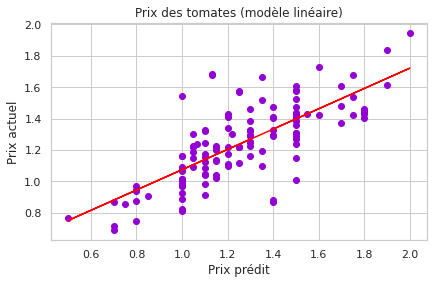

In [ ]:
plt.scatter(y_test, y_pred, color = 'darkviolet')
plt.title('Prix des tomates (modèle linéaire)')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv = 5)

print (scores, np.mean(scores), np.std(scores))


[0.49691933 0.61188789 0.74332777 0.69728193 0.15088023] 0.5400594305100528 0.21190458841741233


In [ ]:
from sklearn.model_selection import cross_val_predict
predictionsp1t = cross_val_predict(model, X_test, y_test, cv = 5) 

In [ ]:
sqrt(mean_squared_error(y_test, predictionsp1t))

0.22847487860628166

In [ ]:
predictionsp1T = cross_val_predict(model, X_train, y_train, cv = 5) 
sqrt(mean_squared_error(y_train, predictionsp1T))

0.19332956668833567

In [ ]:
mean_absolute_error(y_train, predictionsp1T)

0.1455446084646085

In [ ]:
mean_absolute_error(y_test, predictionsp1t)

0.17257559677925405

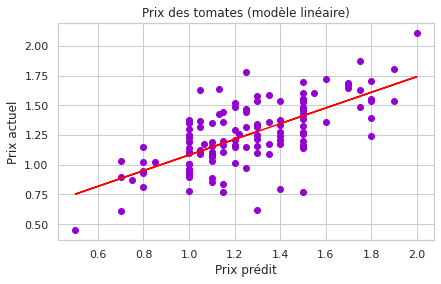

In [ ]:
plt.scatter(y_test, predictionsp1t, color = 'darkviolet')
plt.title('Prix des tomates (modèle linéaire)')
plt.xlabel('Prix prédit')
plt.ylabel('Prix actuel')
z = np.polyfit(y_test, predictionsp1t, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='red')
plt.show()

In [ ]:
#Pour la production

from sklearn.model_selection import train_test_split

X2 =  T3.drop("Production quantité \ntonne(s)", axis=1)
y2 = Production

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [ ]:
model = lr.fit(X_train, y_train)
model.score(X_test, y_test)

-0.18923194583897307

In [ ]:
model.score(X_train, y_train)

0.3579593781601905

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
sqrt(mean_squared_error(y_test, y_pred))

0.7848627892857538

In [ ]:
sqrt(mean_squared_error(y_train, y_tr))

1.1779046739848495

In [ ]:
mean_absolute_error(y_train, y_tr)

1.0213609181968

In [ ]:
mean_absolute_error(y_test, y_pred)

0.43424304426952787

In [ ]:
print(r2_score(y_test, y_pred))
print(r2_score(y_train, y_tr))

-0.18923194583897307
-1.1823358920996605


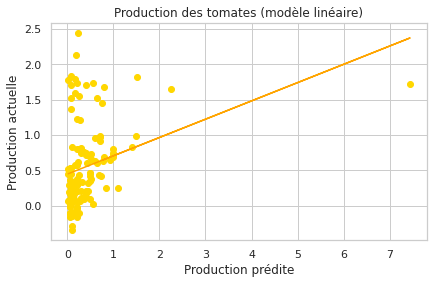

In [ ]:
plt.scatter(y_test, y_pred, color = 'gold')
plt.title('Production des tomates (modèle linéaire)')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='orange')
plt.show()

In [ ]:
predictionsp2t = cross_val_predict(model, X_test, y_test, cv = 5) 
predictionsp2T = cross_val_predict(model, X_train, y_train, cv = 5) 

In [ ]:
sqrt(mean_squared_error(y_test, predictionsp2t))

0.9008642687157702

In [ ]:
sqrt(mean_squared_error(y_train, predictionsp2T))

0.7936959268764038

In [ ]:
mean_absolute_error(y_train, predictionsp2T)

0.4556273508064612

In [ ]:
mean_absolute_error(y_test, predictionsp2t)

0.5349929527670816

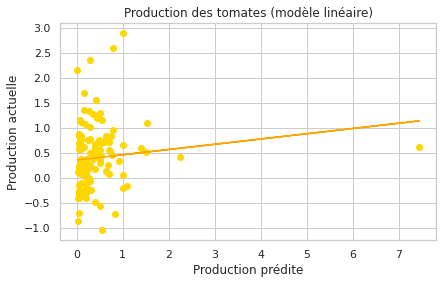

In [ ]:
plt.scatter(y_test, predictionsp2t, color = 'gold')
plt.title('Production des tomates (modèle linéaire)')
plt.xlabel('Production prédite')
plt.ylabel('Production actuelle')
z = np.polyfit(y_test, predictionsp2t, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='orange')
plt.show()